In [1]:
# vocab.py #用于管理验证码词汇
import random
import numpy as np
'''
    A default vocab implementation and base class, to provide random letters and numbers.
'''
class Vocab():
    def __init__(self):
        self.vocab = "123456789abcdefghijklmnopqrstuvwxyz"
        self.size = len(self.vocab)
        indices = range(self.size)
        self.index = dict(zip(self.vocab, indices))
    # return random string by given length
    def rand_string(self, length):
        # if len(vocab) == 0 raise exception
        return "".join(random.sample(self.vocab, length))
    # get symbol (char in vocabulary) by its ordinal
    def get_sym(self, idx):
        # if idx >= len(self.vocab) raise exception
        return self.vocab[idx]
    # given a symbol, return its ordinal in given vocabulary.
    def get_index(self, sym):
        return self.index[sym]
    # given 'abc', return [10, 11, 12]
    def to_indices(self, text):
        return [self.index[c] for c in text]
    # given [10, 11, 12], return 'abc'
    def to_text(self, indices):
        return "".join([self.vocab[i] for i in indices])
    # given '01', return vector [1 0 0 0 0 0 0 0 0 0 ... 0 \n 0 1 0 0 0 0 ... 0]
    def text_to_one_hot(self, text):
        num_labels = np.array(self.to_indices(text))
        n = len(text)
        categorical = np.zeros((n, self.size))
        categorical[np.arange(n), num_labels] = 1
        return categorical.ravel()
    # translate one hot vector to text.
    def one_hot_to_text(self, onehots):
        text_len = onehots.shape[0] // self.size
        onehots = np.reshape(onehots, (text_len, self.size))
        indices = np.argmax(onehots, axis = 1)
        return self.to_text(indices)
if __name__ == "__main__":
    # test code
    vocab = Vocab()
    print(vocab.rand_string(4))
    print(vocab.get_sym(10))
    print(vocab.get_index('a'))
    print(vocab.size)
    print(vocab.text_to_one_hot("abc"))

dvly
b
9
35
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
# PIL是一个常用的python图像库。在python 3.5中， 应该使用pip install pillow来安装
from PIL import Image, ImageFont, ImageDraw, ImageFilter
import random
from vocab import Vocab
class Captcha:
    '''
    size: width, height in pixel
    font: font family(string), size (unit pound) and font color (in "#rrggbb" format)
    bgcolor: in "#rrggbb" format
    '''
    def __init__(self, size, font, bgcolor, length = 4):
        #todo: add param check and transform here
        self.width, self.height = size
        self.font_family, self.font_size, self.font_color = font
        self.bgcolor = bgcolor
        self.len = length
        self.vocab = Vocab()
        self.font = ImageFont.truetype(self.font_family, self.font_size)
    def get_text(self):
        return self.vocab.rand_string(self.len)
    # by default, draw center align text
    def draw_text(self, str):
        dr = ImageDraw.Draw(self.im)
        font_width, font_height = self.font.getsize(str)
        # don't know why, but for center align, I should divide it by 2, other than 3
        dr.text(((self.width - font_width) / 3, (self.height - font_height) / 3), str, fill = self.font_color, font = self.font)
    def draw_background(self):
        pass
    def transform(self):
        params = [1 - float(random.randint(1, 2)) / 100,
                  0,
                  0,
                  0,
                  1 - float(random.randint(1, 10)) / 100,
                  float(random.randint(1, 2)) / 500,
                  0.001,
                  float(random.randint(1, 2)) / 500
                  ]
        self.im = self.im.transform((self.width, self.height), Image.PERSPECTIVE, params)
    def filter(self):
        self.im.filter(ImageFilter.EDGE_ENHANCE_MORE)
    # by default, add no noises
    def add_noise(self):
        pass
    def get_captcha(self):
        self.im = Image.new("RGB", (self.width, self.height), (self.bgcolor))
        self.draw_background()
        str = self.get_text()
        self.draw_text(str)
        #self.add_noise()
        #dself.transform()
        self.filter()
        return self.im, str
class JrttCaptcha(Captcha):
    def __init__(self, size = (60, 25), font = ("courbd.ttf", 20, "#0000ff"), bgcolor = (255, 255, 255), dot_rate = 0.05):
        Captcha.__init__(self, size, font, bgcolor)
        self.dot_rate = dot_rate
    def add_noise(self):
        # add lines
        nb_lines = random.randint(1, 2)
        dr = ImageDraw.Draw(self.im)
        for i in range(nb_lines):
            # 避免begin和end太靠近，导致生成的干扰线太短
            begin = (random.randint(0, self.width)/2, random.randint(0, self.height)/2)
            end = (random.randint(self.width / 2, self.width), random.randint(0, self.height))
            dr.line([begin, end], fill = (0, 0, 0))
        # add dots
        for w in range(self.width):
            for h in range(self.height):
                if random.randint(0, 100) / 100 <= self.dot_rate:
                    dr.point((w, h), fill = (0, 0, 0))
    def draw_text(self, str):
        display_text = [" "] * (len(str) * 2 - 1)
        for i in range(len(str)):
            display_text[i * 2] = str[i]
        super().draw_text(str)
if __name__ == "__main__":
    cap = JrttCaptcha()
    #每调用一次，生成一个<图像,文本>对。其中图象可看成是输入，而文本可以看成是真值
    img, text = cap.get_captcha()
    img.save(text +"_" +str(random.randint(0,100)) + ".jpg")
    print(text)

Xid7


In [1]:
import cv2
import os
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.utils.data as tud
import pdb
import random
import struct
import gzip

In [3]:
# import cv2
# import os
# def find_file_name(file_dir):#获取文件夹下所有文件名
#     for root, dirs, files in os.walk(file_dir):
#         return files
# files_name = find_file_name('data')


# for n in range(300):
#     img = cv2.imread('data/'+files_name[n])
#     for i in range(4):
#         cropped = img[0:25, 15*(i):15*(i+1)]  # 裁剪坐标为[y0:y1, x0:x1]
#         cv2.imwrite("data/one/"+str(n)+"_"+str(i)+"_"+str(files_name[n][i])+".jpg", cropped)

In [4]:
from PIL import Image
import cv2
import numpy as np
import os
def judge(img):
    for i in range(15):
        img[0][i] = 255
        img[24][i] = 255
    for i in range(25):
        img[i][0] = 255
        img[i][14] = 255
    for x in range(23):
        x = x+1
        for y in range(13):
            y = y+1
            m = 0
            if(0 == img[x-1][y-1]):
                m = m+1
            if(0 == img[x-1][y]):
                m = m+1
            if(0 == img[x-1][y+1]):
                m = m+1
            if(0 == img[x][y-1]):
                m = m+1
            if(0 == img[x][y+1]):
                m = m+1
            if(0 == img[x+1][y-1]):
                m = m+1
            if(0 == img[x+1][y]):
                m = m+1
            if(0 == img[x+1][y+1]):
                m = m+1
            if m<3:
                img[x][y] = 255
    for x in range(23-1,-1,-1):
        x = x+1
        for y in range(13-1,-1,-1):
            y = y+1
            m = 0
            if(0 == img[x-1][y-1]):
                m = m+1
            if(0 == img[x-1][y]):
                m = m+1
            if(0 == img[x-1][y+1]):
                m = m+1
            if(0 == img[x][y-1]):
                m = m+1
            if(0 == img[x][y+1]):
                m = m+1
            if(0 == img[x+1][y-1]):
                m = m+1
            if(0 == img[x+1][y]):
                m = m+1
            if(0 == img[x+1][y+1]):
                m = m+1
            if m<3:
                img[x][y] = 255
    return img
def find_file_name(file_dir):#获取文件夹下所有文件名
    for root, dirs, files in os.walk(file_dir):
        return files
#全局阈值
def threshold_demo(image):#二值化函数
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #把输入图像灰度化
    #直接阈值化是对输入的单通道矩阵逐像素进行阈值分割。
#     ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)
#     print("threshold value %s"%ret)
    binary = gray
    return binary
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
files_name = find_file_name('data/one')#获取所有文件名
# src = cv2.imread('data/one/'+files_name[0])
CEL = True #CEL 代表CrossEntropyLoss 此loss方程需要需要的结果y和其他loss方程不一样（单维），所以需要另外处理
add = [255 for i in range(125)]
add = np.array(add)
add = add.reshape(25,5)
data_image = [[np.c_[add,judge(threshold_demo(cv2.imread('data/one/'+n))),add]] for n in files_name]#生成二值化之后的数据#其中做了judge，去噪，拼接矩阵#这一行非常复杂，需要理解很久
data_lable = [n.split("_")[2][0] for n in files_name]
ind = "123456789abcdefghijklmnopqrstuvwxyz"
data_lable = [ind.index(n) for n in data_lable]#转换成数字标签
datas = np.array(data_image) #datas的类型从list转换为numpy
lable = np.array(data_lable) #lable的类型从list转换为numpy
lable = lable.astype(np.int) #把lable里面数据强转为int
datas = datas.astype(np.float32) #把atas里面数据强转为float32
training_image = torch.from_numpy(datas) #把datas变成torch类型的矩阵(torch可以使用gpu)
training_lable = torch.from_numpy(lable) #同理

101_3_4.jpg
[1, 7, 11, 2, 12, 11, 5, 30, 12, 12, 4, 3, 12, 16, 22, 12, 12, 18, 19, 4, 12, 22, 10, 6, 12, 25, 33, 33, 12, 27, 32, 13, 12, 28, 15, 33, 12, 30, 11, 31, 12, 31, 27, 33, 2, 17, 26, 32, 13, 7, 18, 26, 13, 24, 30, 27, 13, 31, 2, 12, 14, 1, 14, 27, 14, 3, 14, 13, 14, 10, 24, 4, 14, 11, 33, 25, 14, 12, 9, 1, 14, 14, 6, 1, 14, 22, 31, 11, 2, 18, 25, 15, 14, 24, 10, 30, 14, 27, 1, 33, 14, 32, 30, 13, 14, 34, 27, 3, 15, 5, 26, 25, 15, 7, 18, 27, 15, 16, 32, 30, 15, 18, 3, 2, 15, 18, 19, 2, 15, 24, 24, 18, 2, 26, 12, 16, 15, 26, 10, 27, 16, 3, 7, 16, 16, 6, 13, 5, 16, 11, 34, 7, 16, 17, 28, 2, 16, 18, 15, 10, 16, 18, 15, 31, 16, 22, 3, 14, 16, 27, 16, 19, 16, 30, 25, 29, 3, 1, 1, 1, 17, 1, 15, 30, 17, 14, 13, 30, 17, 17, 24, 1, 17, 27, 9, 21, 17, 32, 32, 26, 17, 32, 32, 32, 18, 6, 2, 5, 18, 12, 10, 1, 18, 25, 16, 33, 19, 7, 18, 31, 3, 5, 4, 6, 19, 10, 14, 15, 19, 13, 30, 10, 19, 17, 17, 11, 19, 24, 6, 3, 19, 26, 30, 2, 19, 27, 14, 21, 19, 30, 1, 12, 19, 32, 14, 1, 21, 2, 31, 14, 21,

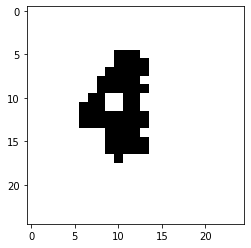

In [6]:
import matplotlib.pyplot as plt
datas = np.array(data_image) #datas的类型从list转换为numpy
m = 11
print(files_name[m])
print(data_lable)
print(len(files_name))
files_name_all = files_name[m].split("_")
# print(files_name_all[2][0])
# add = [255 for i in range(125)]
# add = np.array(add)
# add = add.reshape(25,5)
# result = np.c_[add,datas[m][0],add]
# for n in datas:
a = datas[m][0].reshape(25,25) #显示图片
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(a , cmap='gray')
plt.show()

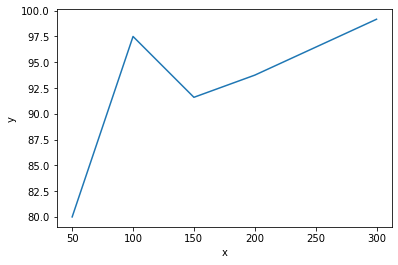

In [27]:
y = [50,100,150,200,300]
x = [80,97.5,91.6,93.75,99.17]
plt.plot(y,x)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [10]:
def threshold_demo(image):#二值化函数
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #把输入图像灰度化
    #直接阈值化是对输入的单通道矩阵逐像素进行阈值分割。
    ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)
#     print("threshold value %s"%ret)
    return binary

In [209]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(len(ind))

35


106_2_x.jpg


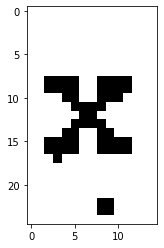

NameError: name 'dst' is not defined

In [21]:
m = 30
img = cv2.imread('data/one/'+files_name[m])
# img = cv2.fastNlMeansDenoisingColored(img,None,20,20,7,21)
img = threshold_demo(img)
img = judge(img)
print(files_name[m])
a = img.reshape(25,15) #显示图片
fig = plt.figure()
plotwindow = fig.add_subplot(111)
plt.imshow(a , cmap='gray')
plt.show()

print(dst.shape)
cv2.imwrite("123.png", dst)

In [7]:
import torch as t
 
class ResidualBlock(nn.Module):
    #实现子module: Residual    Block
    def __init__(self,inchannel,outchannel,stride=1,shortcut=None):
        super(ResidualBlock,self).__init__()
        self.left=nn.Sequential(
            nn.Conv2d(inchannel,outchannel,3,stride,1,bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),
            nn.BatchNorm2d(outchannel)
        )
        
        self.right=shortcut
        
    def forward(self,x):
        out=self.left(x)
        residual=x if self.right is None else self.right(x)
        out+=residual
        return F.relu(out)
    
    
class ResNet(nn.Module):
    #实现主module:ResNet34
    #ResNet34包含多个layer,每个layer又包含多个residual block
    #用子module实现residual block , 用 _make_layer 函数实现layer
    def __init__(self,num_classes=1000):
        super(ResNet,self).__init__()
        #重复的layer,分别有3,4,6,3个residual block
        self.BN = nn.BatchNorm2d(1)
#         48-3+1 = 46
#         (46-3-1)/2 = 21
#         (21-5-1)/2 = 21
# torch.Size([64, 64, 25, 25])
# torch.Size([64, 128, 13, 13])
# torch.Size([64, 256, 7, 7])
# torch.Size([64, 512, 4, 4])
#         25-2+1 = 24
#         (24-2)/2+1
        self.layer1=self._make_layer(1,64,2)
        self.layer2=self._make_layer(64,128,3,)
        self.layer3=self._make_layer(128,256,2,stride=2)
        self.layer4=self._make_layer(256,512,2,stride=2)
        
        #分类用的全连接
        self.fc=nn.Linear(512,num_classes)
        
    def _make_layer(self,inchannel,outchannel,block_num,stride=1):
        #构建layer,包含多个residual block
        shortcut=nn.Sequential(
            nn.Conv2d(inchannel,outchannel,1,stride,bias=False),
            nn.BatchNorm2d(outchannel))
 
        layers=[ ]
        layers.append(ResidualBlock(inchannel,outchannel,stride,shortcut))
        
        for i in range(1,block_num):
            layers.append(ResidualBlock(outchannel,outchannel))
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.BN(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=F.avg_pool2d(x,7)
        x=x.view(x.size(0),-1)
        return self.fc(x)

In [39]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,20,2)

#       25-2+1 = 24
#       
        #pooling
#       5*5
        self.conv2 = torch.nn.Conv2d(20,20,3)
        self.linear1 = torch.nn.Linear(20*5*5,300)
        self.linear5 = torch.nn.Linear(300,200)
        self.linear6 = torch.nn.Linear(200,100)
        self.linear7 = torch.nn.Linear(100,7)
    def forward(self,x):
        x = F.relu(self.conv1(x))
#         print(x[0][1])
#         pdb.set_trace()
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1,20*5*5)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear5(x))
        x = F.relu(self.linear6(x))
        x = F.relu(self.linear7(x))
#         print(F.softmax(x, dim = 1)) #调试语句
#         pdb.set_trace()
        return x

In [28]:
class ExpressionClassificationDataset(tud.Dataset): #定义数据读取类，此类用于读取数据，最为关键的函数是getitem（）
    def __init__(self,training_image,training_lable, CEL): #此函数用于初始化
        super(ExpressionClassificationDataset, self).__init__()
        self.training_data = training_image.to(DEVICE)
        if(CEL == True): #CEL 代表CrossEntropyLoss 此loss方程需要需要的结果y和其他loss方程不一样（单维），所以需要另外处理
            self.training_lable = training_lable.to(DEVICE)
        else:
            self.training_lable = torch.zeros(len(training_lable),7,device = DEVICE)
            for i in range(len(training_lable)):
                self.training_lable[i][training_lable[i]] = 1
        
    def __len__(self): #此函数用于确定总数据大小，用于生成所有的bitch
        return len(self.training_data)
    def __getitem__(self, idx):
        
        return self.training_data[idx]/255.,self.training_lable[idx]; #/255是把数据的大小限制在0-1之间，能极大减少学习的时间

In [8]:
#接下来使用dataset将数据封装成batch(成组)
#dataset类有三个重要函数，
#__init__初始化 在创建此类的时候魂运行一次，用于将数据读入类中
#__len__测量大小，用于和下面那个函数配合使用
#__getitem__，此函数是dataset可以生成batch的关键函数，此函数的返回值代表取出一个数据。
#则此类会成组的调用__getitem__来生成数据，把每一个返回值拼装成成组的数据
#例如，batch_size设定为40，则此类就会成组的运行40次__getitem__来返回数据，每40次把数据合成一组
#一共运行__len__返回值除以40次，也就是生成__len__返回值除以40组的数据
class ExpressionClassificationDataset(tud.Dataset): #定义数据读取类，此类用于读取数据，最为关键的函数是getitem（）
    def __init__(self,training_image,training_lable, CEL): #此函数用于初始化
        super(ExpressionClassificationDataset, self).__init__()
        self.training_data = training_image.to(DEVICE)
        if(CEL == True): #CEL 代表CrossEntropyLoss 此loss方程需要需要的结果y和其他loss方程不一样（单维），所以需要另外处理
            self.training_lable = training_lable.to(DEVICE)
        else:
            self.training_lable = torch.zeros(len(training_lable),7,device = DEVICE)
            for i in range(len(training_lable)):
                self.training_lable[i][training_lable[i]] = 1
        
    def __len__(self): #此函数用于确定总数据大小，用于生成所有的bitch
        return len(self.training_data)
    def __getitem__(self, idx):
        return self.training_data[idx]/255.,self.training_lable[idx]; #/255是把数据的大小限制在0-1之间，能极大减少学习的时间

In [30]:
dataset = ExpressionClassificationDataset(training_image,training_lable,CEL = CEL)#用training_image和training_lable生成dataset类
train_loader = tud.DataLoader(dataset,batch_size = 40, shuffle = False)#把数据提取成组,shuffle的意思是是否随机抽取

In [9]:
class ExpressionClassification(object):
    def __init__(self,training_image,training_lable,eta,batch_size,shuffle,CEL,model = None): #CEL 代表使用交叉熵计算loss
        self.CEL = CEL
        self.dataset = ExpressionClassificationDataset(training_image,training_lable,CEL = self.CEL)
        self.split_9_1(len(training_image),batch_size) #把数据分为训练集和测试集  详细过程见下面的那个split函数
        self.dataloader = tud.DataLoader(self.dataset, batch_size=batch_size, shuffle=shuffle)
        if(None != model):
            self.model = torch.load(model,map_location='cpu')
        else:
            if torch.cuda.is_available():
                self.model = ResNet(35).cuda()  #定义模型类
            else:
                self.model = ResNet(35)
        if (CEL == True):
            self.loss_fn = torch.nn.CrossEntropyLoss() #定义loss_fn，loss方程
        else:
            self.loss_fn = torch.nn.MSELoss() #定义loss_fn，loss方程
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr = eta)#定义参数更新方式
    def train(self): #开始训练
        for e in range(NUM_EPOCHS): #每一个epochs
            for i,(x,y) in enumerate (self.train_loader): #从dataloader中取出bitch数据进行训练
#                 a = x[0].reshape(28,28) #显示图片
#                 fig = plt.figure()
#                 plotwindow = fig.add_subplot(111)
#                 plt.imshow(a , cmap='gray')
#                 plt.show()
#                 print(y[0])
                y_pred = self.model.forward(x)  #前项传播
                
                
                if self.CEL == True:
                    self.loss = self.loss_fn(y_pred,y.long()) #计算loss
                else:
                    self.loss = self.loss_fn(y_pred,y) #计算loss
#                 if(i % 5 ==0):
#                     print(y_pred)
# #                 print(self.loss)
#                 print(self.loss)
                self.optimizer.zero_grad() #参数更新器重置为0
                self.loss.backward()   # 反向传播
                self.optimizer.step() #参数更新
                
            print(e,":轮，loss = ",self.loss.item())
            accuracy = self.test()
            if e >= 100 and accuracy.item() >= 0.9:
              print("准确率到90，保存模型")
              torch.save(self.model,"model.pth")
            print("准确率为：",accuracy);
    def test(self): #测试函数
        total_correct = 0.0
        for i, (x,y) in enumerate(self.test_loader):
            y_pred = self.model.forward(x)  #前项传播
            if self.CEL == True:  #对于不同loss方程的处理
                correct = self.correct_count_CEL(y,y_pred)
            else:
                correct = self.correct_count_MSE(y,y_pred)

            total_correct = total_correct+correct
#             pdb.set_trace()
        
        return total_correct/self.test_number
    def correct_count_MSE(self,y,y_pred): #MES正确预测数量函数
        return sum(a[torch.argmax(b)] == 1 for a, b in zip(y,y_pred))
    def correct_count_CEL(self,y,y_pred): #CrossEntropyLoss正确预测数量函数
        return sum(a == torch.argmax(b) for a, b in zip(y,y_pred))
    def split_9_1(self,n_train,batch_size):
        split = n_train // 10   #整数除法，要把数据分成9:1的训练集和测试集
        self.test_number = split  #测试集总数
        indices = list(range(n_train))
        train_sampler = tud.sampler.SubsetRandomSampler(indices[split:])  #设置采样器
        test_sampler = tud.sampler.SubsetRandomSampler(indices[:split])
        self.train_loader = tud.DataLoader(self.dataset, sampler=train_sampler,batch_size = batch_size, shuffle=False)#利用采样的方法进行提取
        self.test_loader = tud.DataLoader(self.dataset, sampler=test_sampler, batch_size = batch_size, shuffle=False)

In [10]:
NUM_EPOCHS = 300
EC = ExpressionClassification(training_image,training_lable,eta = 0.005,batch_size = 32,shuffle = True,CEL = True,model = "model.pth")
print(EC.test())

tensor(0.9500)


In [14]:
print(EC.test())

tensor(0.9583)
